In [1]:
import torch
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os import listdir, path
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st as C2ST
from scipy import stats
import itertools
import pandas as pd
from gbi import distances
from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture

import gbi.utils.utils as gbi_utils



In [43]:
task_name = "uniform_1d"
inference_dir = "../results/benchmark/algorithms/"
print(np.sort(listdir(f"{inference_dir}/{task_name}/")))
inference_datetime = np.sort(listdir(f"{inference_dir}/{task_name}/"))[-1]
print(inference_datetime)
collection_datetime=np.sort(listdir(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/"))[-1]
df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/posterior_samples_collected/{collection_datetime}/summary_collected.csv", index_col=0)
# df_summaries = df_summaries.drop(df_summaries[df_summaries['algorithm']=='eGBI'].index)

betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()

['2023_02_03__19_24_25' '2023_02_06__19_18_26' '2023_04_07__19_18_18'
 '2023_04_27__15_17_21']
2023_04_27__15_17_21


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


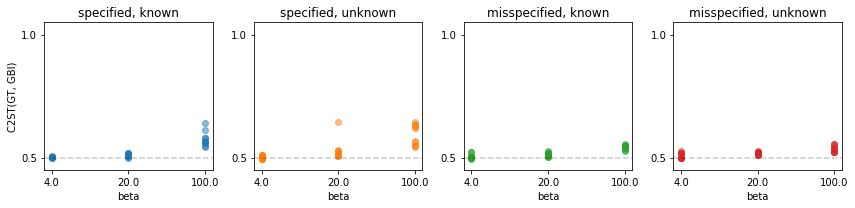

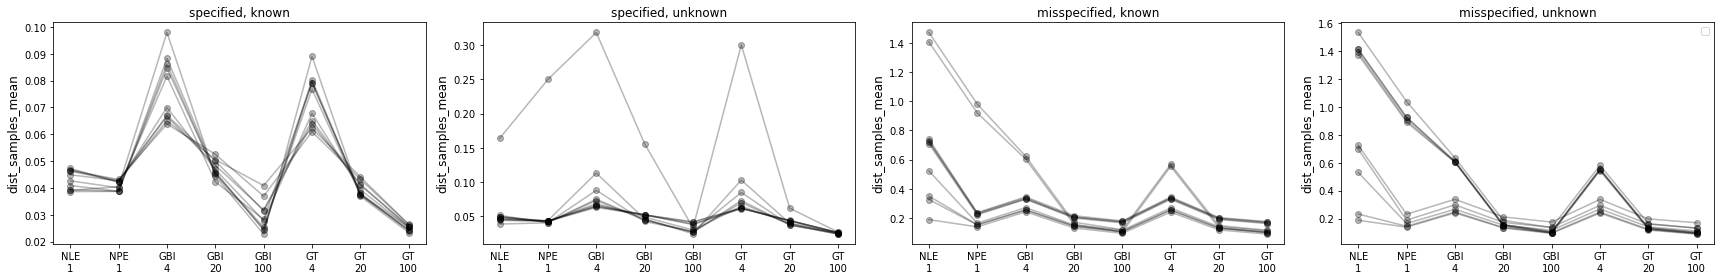

In [44]:
plt.figure(figsize=(12,3))

for i_s, specified in enumerate(['specified', 'misspecified']):
    for i_k, known in enumerate(['known', 'unknown']):
        plt.subplot(1,4,i_s*2+i_k+1)            
        for xo in range(10):
            df_cur = df_summaries[(df_summaries['algorithm']=="GBI")&(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]            
            
            plt.plot(range(len(df_cur['beta'])), df_cur['c2st'], 'o', color=f"C{i_s*2+i_k}", alpha=0.5)
            
        plt.xticks(ticks=range(3),labels=df_cur[df_cur['algorithm']=='GBI']['beta'].unique())        
        plt.ylim([0.45,1.05]); plt.yticks([0.5,1])
        plt.axhline(0.5, alpha=0.2, color='k', linestyle='--')
        plt.title(f"{specified}, {known}")
        plt.xlabel('beta')

plt.subplot(1,4,1)
plt.ylabel('C2ST(GT, GBI)')
plt.tight_layout()
metric_to_plot = 'dist_samples_mean'
# metric_to_plot = 'mse_dist_gt_estimate'
# metric_to_plot = 'r_dist_gt_estimate'
plt.figure(figsize=(24,4))
for i_s, specified in enumerate(['specified', 'misspecified']):
    for i_k, known in enumerate(['known', 'unknown']):
        plt.subplot(1,4,i_s*2+i_k+1)            
        for xo in range(10):
            df_cur = df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]     
            # df_cur = df_cur.iloc[[6,7,8,3,4,5, 11,12,13, 10,9,0,1,2]]       
            for i_, i_b in enumerate([3,4,5]):
#                 # GBI GT vs. GBI estimated
#                 plt.plot(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], 'o', color=f"C{i_}", label=betas[i_] if xo==0 else None, alpha=0.5)
#                 # plt.errorbar(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], xerr=df_cur['dist_sample_std'].iloc[-1], yerr=df_cur['dist_sample_std'].iloc[i_b], color=f"C{i_}", alpha=0.1)
                
#                 # NPE vs. GBI estimated
#                 plt.plot(df_cur['dist_sample_mean'].iloc[i_b-3], df_cur['dist_sample_mean'].iloc[i_b], '*', color=f"C{i_}", alpha=0.5)

                plt.plot(df_cur[metric_to_plot].values, 'ok-', alpha=0.1)
        plt.xticks(range(len(df_cur)), labels=[f"{row['algorithm']}\n{row['beta']:.0f}" for _, row in df_cur.iterrows()])
        
        # XL = [0,plt.ylim()[1]]
        # plt.plot(XL, XL, 'k--', alpha=0.1)            
        plt.title(f"{specified}, {known}")
        plt.ylabel(metric_to_plot, fontsize=12)
        # plt.ylim(0,df_summaries['dist_sample_mean'].max())
        # plt.xticks(XL);plt.yticks(XL);
        # plt.xlabel('GT/NPE'); plt.ylabel('GBI')
        # plt.xscale('log')
        # plt.yscale('log');

plt.legend()
plt.tight_layout()




# df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]

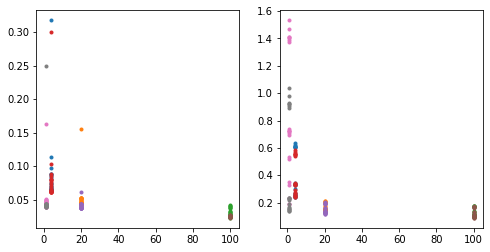

In [45]:
plt.figure(figsize=(8,4))
for group_alg, rows_alg in df_summaries.groupby('algorithm'):
    
    for group_beta, rows_beta in rows_alg[rows_alg['xo_specified']=='specified'].groupby('beta'):
        plt.subplot(1,2,1)        
        plt.plot(rows_beta['beta'].values, rows_beta[metric_to_plot].values, '.')
        
    for group_beta, rows_beta in rows_alg[rows_alg['xo_specified']=='misspecified'].groupby('beta'):
        plt.subplot(1,2,2)
        plt.plot(rows_beta['beta'].values, rows_beta[metric_to_plot].values, '.')

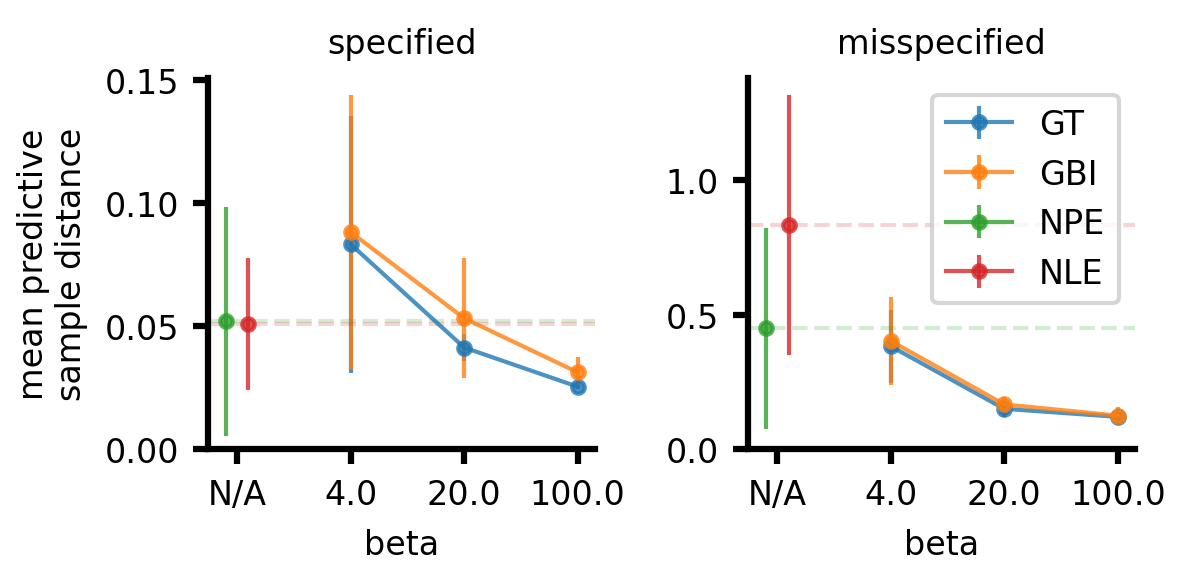

In [74]:
df_collapsed = df_summaries.groupby(['algorithm','beta','xo_specified']).describe()[metric_to_plot]
with mpl.rc_context(fname="../.matplotlibrc"):
    plt.figure(figsize=(4,2), dpi=300)
    for i_a, alg in enumerate(['GT', 'GBI', 'NPE', 'NLE']):
        for i_s, is_specified in enumerate(['specified', 'misspecified']):
            df_cur = df_collapsed.loc[alg, :, is_specified]
            plt.subplot(1,2,i_s+1)
            if alg in ['GT', 'GBI']:
                plt.errorbar(range(len(df_cur['mean'])), df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o', ecolor=f'C{i_a}', label=alg, lw=1, alpha=0.8)
            elif alg in ['NLE', 'NPE']:
                plt.errorbar(-1+((i_a%2)-0.5)*0.2, df_cur['mean'].values, yerr=df_cur['std'].values, fmt='-o', ecolor=f'C{i_a}', label=alg, lw=1, alpha=0.8)
                plt.axhline(df_cur['mean'].values, color=f'C{i_a}', ls='--', alpha=0.2, lw=1)
                # plt.fill_between([-1,3], df_cur['mean'].values+df_cur['std'].values, df_cur['mean'].values-df_cur['std'].values, alpha=0.1, color=f'C{i_a}')

            # plt.xlim([-0.25,2.25])
            
            plt.xticks([-1,0,1,2], ['N/A']+list(df_collapsed.loc['GBI',:,'specified'].index.values))
            plt.xlabel('beta'); 
            if i_s==0: plt.ylabel('mean predictive\nsample distance')
            plt.title(is_specified)
        
            if i_a==3: plt.ylim(0, None)
            
    plt.subplot(1,2,2)
    plt.legend(frameon=True)
    plt.tight_layout()

array([ 10.,  50., 250.])

([<matplotlib.axis.XTick at 0x7fcd990cd6a0>,
 [Text(0, 0, 'GT\n0.1'),
  Text(1, 0, 'GT\n1.0'),
  Text(2, 0, 'GT\n10.0'),
  Text(3, 0, 'GBI\n0.1'),
  Text(4, 0, 'GBI\n1.0'),
  Text(5, 0, 'GBI\n10.0'),
  Text(6, 0, 'NPE\n1.0'),
  Text(7, 0, 'NLE\n1.0'),
  Text(8, 0, 'ABC\n0.1'),
  Text(9, 0, 'ABC\n1.0'),
  Text(10, 0, 'ABC\n10.0')])

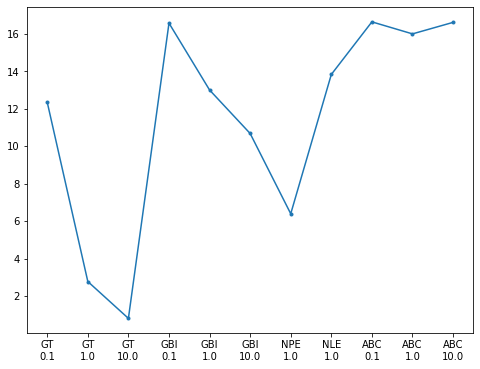

In [155]:
# plt.figure(figsize=(8,6))
# plt.plot(df_cur['dist_sample_mean'].values, '.-')

# plt.xticks(range(len(df_cur)), labels=[f"{row['algorithm']}\n{row['beta']}" for _, row in df_cur.iterrows()])


,task,xo_idx,xo_specified,xo_known,algorithm,beta,theta_mean,theta_std,x_pred_mean,x_pred_std,dist_gt_mean,dist_gt_std,dist_sample_mean,dist_sample_std,dist_estimate_mean,dist_estimate_std,r_gt_estimate,mse_gt_estimate,c2st
430,linear_gaussian,9,misspecified,unknown,GT,0.1,[-0.60354733 0.73854727 0.2538359 -0.469959...,[0.9213561 0.9046386 0.9182231 0.9239822 0...,[ 0.9246588 0.44322157 -1.9320601 0.105068...,[1.2101465 1.0022993 1.3131821 1.4023372 1...,123.361060,19.308428,12.350277,2.633588,12.794785,3.212799,0.364763,12562.74700,NaN
431,linear_gaussian,9,misspecified,unknown,GT,1.0,[-2.4004538 2.977598 1.0612355 -1.895249...,[0.5753393 0.5769134 0.5799474 0.5774087 0...,[-0.87224764 2.6822722 -1.1246604 -1.320221...,[0.9612582 0.7214652 1.0807295 1.2091955 1.196...,27.747965,5.005708,2.775645,0.980968,8.965590,2.938405,-0.022683,387.13284,NaN
432,linear_gaussian,9,misspecified,unknown,GT,10.0,[-3.4211357 4.2457976 1.5114169 -2.708521...,[0.21839488 0.21864036 0.21745524 0.21871024 0...,[-1.8929297 3.9504724 -0.6744791 -2.133493...,[0.80996597 0.47754818 0.9415768 1.0767184 1...,8.095148,0.335715,0.807863,0.407285,12.022683,1.123166,-0.309322,17.03285,NaN
433,linear_gaussian,9,misspecified,unknown,GBI,0.1,[-0.08620115 0.10825652 0.03252724 -0.030709...,[0.9784684 0.97212577 0.95863575 0.97641724 0...,[ 1.4420049 -0.18706919 -2.1533687 0.544318...,[1.2551022 1.0622507 1.3298491 1.4210019 1.434...,165.690580,24.314410,16.578310,3.194215,15.690104,3.729531,0.681824,22981.53300,NaN
434,linear_gaussian,9,misspecified,unknown,GBI,1.0,[-0.8452158 0.8096459 0.21222548 0.066195...,[0.9324036 0.7693787 0.8173004 0.7988796 0.960...,[ 0.6829903 0.5143202 -1.9736704 0.641223...,[1.2204634 0.87974054 1.2450126 1.3310655 1...,129.883760,18.322557,13.007171,2.639495,7.221627,2.802953,0.537423,15334.34100,NaN
435,linear_gaussian,9,misspecified,unknown,GBI,10.0,[-1.7494082 1.7418195 -0.00708364 0.382673...,[0.91358036 0.5050502 0.70082587 0.6399297 1...,[-0.22120205 1.446494 -2.1929796 0.957702...,[1.1933396 0.6607025 1.1575685 1.2334466 1.589...,106.660484,15.128628,10.684113,2.336683,0.416513,0.348877,-0.062573,11517.41800,NaN
436,linear_gaussian,9,misspecified,unknown,NPE,1.0,[-1.9914154 2.5474265 0.76693666 -1.682985...,[0.5528962 0.12083537 0.62321573 0.7060223 0...,[-0.46320933 2.2521007 -1.4189593 -1.107957...,[0.9480283 0.4443868 1.1117085 1.2742189 1...,63.882650,9.702874,6.396645,1.674591,10.879135,3.120982,0.378669,2890.31710,NaN
437,linear_gaussian,9,misspecified,unknown,NLE,1.0,[-0.55271107 0.11375962 1.6671815 -1.005869...,[0.9633565 0.9436382 0.57575893 0.91592354 0...,[ 0.9754951 -0.18156606 -0.5187145 -0.430841...,[1.2386991 1.0373169 1.0876957 1.390054 1.350...,138.339520,21.856682,13.836873,2.864978,15.857097,4.399594,0.450613,15412.31300,NaN
438,linear_gaussian,9,misspecified,unknown,ABC,0.1,[ 0.06143041 0.01569465 0.08452255 0.104212...,[0.739764 0.98292154 0.9337798 0.9562398 1...,[ 1.6149579 -0.35258603 -2.0588696 0.500028...,[1.1136974 1.0172516 1.2996306 1.3601283 1...,167.537250,22.803680,16.646448,2.835982,15.673712,2.745912,0.719075,23491.27500,NaN
439,linear_gaussian,9,misspecified,unknown,ABC,1.0,[-0.0595414 0.14127073 0.145369 -0.360820...,[0.93406546 1.0659785 0.9279257 0.96338844 0...,[ 1.4939862 -0.22700995 -1.998023 0.034995...,[1.1966835 1.1408304 1.5755197 1.464859 1.618...,159.222050,22.605738,16.004494,2.662135,14.952102,2.712493,0.696851,21238.07200,NaN


In [3]:
gt_dir = "../results/benchmark/ground_truths/"
inference_dir = "../results/benchmark/algorithms/"
xo_dir = "../gbi/benchmark/tasks/"

inference_dir = "../results/benchmark/algorithms/"
task_classes = {
    "uniform_1d": UniformNoise1D,
    "two_moons": TwoMoonsGBI,
    "linear_gaussian": LinearGaussian,
    "gaussian_mixture": GaussianMixture
}

# task_betas = {
#     "uniform_1d": ["4","20","100"],
#     "two_moons": ["10","100","1000"],
#     "linear_gaussian": ["0.1","1.0","10.0"],
#     "gaussian_mixture": ["2.0","10.0","50.0"],    
# }

algos = ['GBI', 'NPE', 'NLE']

In [10]:
# load xo, gt posterior samples, and inference samples
task_name = "uniform_1d"
if task_name == "gaussian_mixture":
    distance_func = distances.mmd_dist
else:
    distance_func = distances.mse_dist

betas = task_betas[task_name]
xo_path = f"{xo_dir}/{task_name}/xos/"
gt_datetime = np.sort(listdir(f"{gt_dir}/{task_name}/"))[-1]

inference_dir = "../results/benchmark/algorithms/"
inference_datetime = np.sort(listdir(f"{inference_dir}/{task_name}/"))[-1]

In [11]:
xo_combs = [range(10), ['specified', 'misspecified'], ['known', 'unknown']]
xo_info_combs = list(itertools.product(*xo_combs))

In [32]:
posterior_samples_collected = []


for xo_info in xo_info_combs:
    # load xos and gt theta
    with open(f"{xo_path}/xo_{xo_info[1]}_{xo_info[2]}.pkl", 'rb') as handle:
        xos = pickle.load(handle)

    if xo_info[1]=='specified':
        with open(f"{xo_path}/theta_gt_{xo_info[2]}.pkl", 'rb') as handle:
            theta_gt = pickle.load(handle)
    else:
        theta_gt = torch.ones_like(xos)*torch.nan

    xo = xos[xo_info[0]]
    theta = theta_gt[xo_info[0]]

    # load gt posterior samples
    posterior_samples = {}

    # Take the latest run
    posterior_samples['GT'] = {}
    for beta in betas:
        gt_path = f"{gt_dir}/{task_name}/{gt_datetime}/beta_{beta}/obs_{xo_info[0]}_{xo_info[1]}_{xo_info[2]}"
        with open(gt_path + "/rejection_samples.pkl", "rb") as handle:
            posterior_samples['GT'][f"beta_{beta}"] = pickle.load(handle)


    # load inference samples
    for algo in algos:
        posterior_dir = f"{inference_dir}/{task_name}/{inference_datetime}/{algo}/posterior_inference/"    
        if algo == "GBI":
            with open(f"{inference_dir}/{task_name}/{inference_datetime}/{algo}/inference.pickle", 'rb') as handle:
                gbi_inference = pickle.load(handle)

        # Take the latest run
        if path.isdir(posterior_dir):
            posterior_datetime = np.sort(listdir(posterior_dir))[-1]
            # print(algo)
            posterior_samples[algo] = {}

            for beta in betas:
                ps_path = f"{posterior_dir}/{posterior_datetime}/beta_{beta}/obs_{xo_info[0]}_{xo_info[1]}_{xo_info[2]}/posterior_samples.pkl"
                # print(ps_path)
                if path.exists(ps_path):
                    # posterior sample exists, load
                    with open(ps_path, 'rb') as handle:
                        if algo == "GBI":
                            posterior_samples[algo][f"beta_{beta}"] = pickle.load(handle)                    
                        else:
                            posterior_samples[algo] = pickle.load(handle)
                # else:
                    # print(f"{ps_path} does not exist.")

    posterior_samples_collected.append([xo_info, {"xo": xo, "theta_gt": theta,}, posterior_samples])

In [2]:
inference_dir = "../results/benchmark/algorithms/"
task_classes = {
    "uniform_1d": UniformNoise1D,
    "two_moons": TwoMoonsGBI,
    "linear_gaussian": LinearGaussian,
    "gaussian_mixture": GaussianMixture
}


In [3]:
task_name = 'uniform_1d'
posterior_samples_collected = gbi_utils.pickle_load(f'../results/benchmark/algorithms/{task_name}/2023_02_06__19_18_26/posterior_samples_all.pkl')
if task_name == "gaussian_mixture":
    distance_func = distances.mmd_dist
else:
    distance_func = distances.mse_dist

inference_dir = "../results/benchmark/algorithms/"
inference_datetime = np.sort(listdir(f"{inference_dir}/{task_name}/"))[-1]

gbi_inference = gbi_utils.pickle_load(f"{inference_dir}/{task_name}/{inference_datetime}/GBI/inference.pickle")

In [6]:
# metrics to compute

## GBI evals:
# C2ST against GT posterior 
# posterior moments mean / std
# distance estimate vs. true distance (i.e., task.distance_fn)


## all alg evals
# posterior predictive distance mean / std



In [7]:
def compute_predictives(theta_samples, task, distance_fn_empirical, inference_obj=None):
    predictives = {}
    predictives['theta'] = theta_samples
    # simulate posterior predictives
    predictives['x_pred'] = task.simulate(theta_samples)
    
    # compute posterior predictive distances
    predictives['dist_gt'] = task.distance_fn(theta_samples) # true average distance
    predictives['dist_sample'] = distance_fn_empirical(predictives['x_pred'][:,None,:], task.x_o[None,None,:]) # sample-based estimate
    if inference_obj:
        with torch.no_grad():
            predictives['dist_estimate'] = inference_obj.distance_net(theta_samples, task.x_o.repeat((theta_samples.shape[0], 1))).squeeze(1)
            # predictives['dist_estimate'] = inference_obj.predict_distance(theta_samples, task.x_o) # doesn't exist yet
    else: 
        predictives['dist_estimate'] = None
    return predictives

def compute_moments(predictives):
    summaries = {}
    for k,v in predictives.items():
        summaries[f"{k}_mean"], summaries[f"{k}_std"] = v.mean(0), v.std(0)

    # compute correlation and error between true and estimated distances
    # summaries['r_gt_estimate'], _ = torch.Tensor(stats.pearsonr(predictives['dist_gt'], predictives['dist_estimate']))
    summaries['r_gt_estimate'] = torch.corrcoef(torch.vstack((predictives['dist_gt'], predictives['dist_estimate'])))[0,1]
    summaries['mse_gt_estimate'] = ((predictives['dist_gt']-predictives['dist_estimate'])**2).mean()
    return summaries



# c2st = C2ST(posterior_samples['GT'][f'beta_{beta}'], posterior_samples['GBI'][f'beta_{beta}'])
# print(c2st)


In [ ]:
df_collect = []
for i_x in range(len(posterior_samples_collected)):
    print(i_x, end='|')
    xo_info, xo_theta, posterior_samples = posterior_samples_collected[i_x]
    xo, theta_gt = xo_theta['xo'], xo_theta['theta_gt']

    for alg, samples_alg in posterior_samples.items():
        for beta_str, samples in samples_alg.items():
            beta = float(beta_str.split('_')[-1])
            task = task_classes[task_name](beta=beta, x_o=xo)            

            # compute predictives and summary
            predictives = compute_predictives(samples, task, distance_func, gbi_inference)
            summary = compute_moments(predictives)
            df_summary = pd.DataFrame(summary, dtype=float)

            # compute C2ST against GT GBI posterior if it's a GBI algorithm
            df_summary['c2st'] = torch.nan
            if 'GBI' in alg:
                df_summary['c2st'] = C2ST(samples, posterior_samples['GT'][beta_str])

            df_info = pd.DataFrame([[task_name, *xo_info, alg, beta]], columns=['task', 'xo_idx', 'xo_specified', 'xo_known', 'algorithm', 'beta'])

            df_collect.append(pd.concat((df_info, df_summary), axis=1))

0|1|2|3|4|5|6|7|8|

In [12]:
# df_summaries = pd.concat(df_collect, ignore_index=True)
# df_summaries



In [13]:
df_summaries = pd.read_csv(f"{inference_dir}/{task_name}/{inference_datetime}/comparison_summaries.csv", index_col=0)
betas = df_summaries[df_summaries['algorithm']=='GT']['beta'].unique()

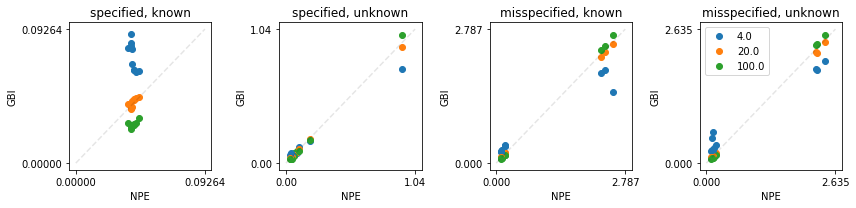

In [14]:
plt.figure(figsize=(12,3))

for i_s, specified in enumerate(['specified', 'misspecified']):
    for i_k, known in enumerate(['known', 'unknown']):
        plt.subplot(1,4,i_s*2+i_k+1)            
        for xo in range(10):
            df_cur = df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]
            
            # plt.plot(df_cur['beta'], df_cur['c2st'], '.', color=f"C{i_s*2+i_k}")
            
            # plt.axhline(0.5, alpha=0.01, color='k')
            # plt.ylim([0.4,1])
            # plt.xticks(df_cur[df_cur['algorithm']=='GBI']['beta'].unique())
            
            for i_, i_b in enumerate([3,4,5]):
                plt.plot(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], 'o', color=f"C{i_}")
                # plt.errorbar(df_cur['dist_sample_mean'].iloc[-1], df_cur['dist_sample_mean'].iloc[i_b], xerr=df_cur['dist_sample_std'].iloc[-1], yerr=df_cur['dist_sample_std'].iloc[i_b], color=f"C{i_}", alpha=0.1)
        
        XL = [0,plt.ylim()[1]]
        plt.plot(XL, XL, 'k--', alpha=0.1)            
        plt.title(f"{specified}, {known}")
        plt.xticks(XL);plt.yticks(XL);
        plt.xlabel('NPE'); plt.ylabel('GBI')
        # plt.xscale('log');plt.yscale('log')

plt.legend(betas)
plt.tight_layout()



# df_summaries[(df_summaries['xo_idx']==xo)&(df_summaries['xo_specified']==specified)&(df_summaries['xo_known']==known)]

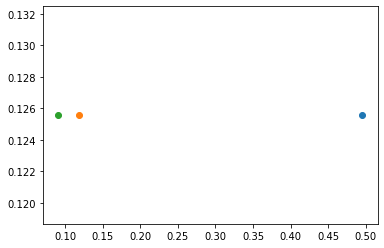

In [46]:

for i_b in [3,4,5]:
    plt.plot(df_cur['dist_sample_mean'].iloc[i_b], df_cur['dist_sample_mean'].iloc[-1], 'o')


In [ ]:
task = task_classes[task_name](beta=float(beta), x_o=xo)
compute_predictives(posterior_samples['NPE'], task, distance_func, gbi_inference)

theta
x_pred
dist_gt
dist_sample
dist_estimate
tensor(0.5937) tensor(0.0002)


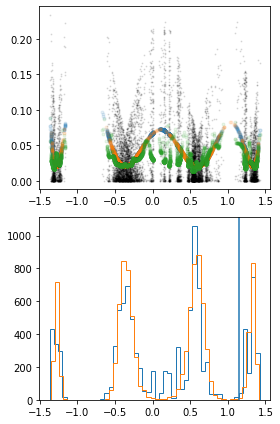

In [45]:
i_x = 0
xo_info, xo_theta, posterior_samples = posterior_samples_collected[i_x]
xo, theta_gt = xo_theta['xo'], xo_theta['theta_gt']

betas = [b.split('_')[-1] for b in posterior_samples['GT'].keys()]
df_info = pd.DataFrame([[task_name, *xo_info, xo, theta_gt]], columns=['task', 'xo_idx', 'xo_specified', 'xo_known', 'xo', 'theta_gt'])





for b_idx, beta in enumerate(betas):
    task = task_classes[task_name](beta=float(beta), x_o=xo)




# get GT predictives
predictives_gt = compute_predictives(posterior_samples['GT'][f'beta_{beta}'], task, distance_func, gbi_inference)

# get GBI predictives
predictives_alg = compute_predictives(posterior_samples['GBI'][f'beta_{beta}'], task, distance_func, gbi_inference)



summaries_alg = compute_moments(predictives_alg)



# # grab GT posterior samples
# theta_posterior_gt = posterior_samples['GT'][f'beta_{beta}']
# theta_gt_mean, theta_gt_std = theta_posterior_gt.mean(0), theta_posterior_gt.std(0)
# x_pred_gt = task.simulate(theta_posterior_gt)
# dist_pred_gt = task.distance_fn(theta_posterior_gt)



# # compute metrics


# theta_posterior_alg = posterior_samples['GBI'][f'beta_{beta}']


# # ---C2ST
# # c2st = C2ST(theta_gt_posterior, theta_posterior)

# # ---posterior moments

# theta_alg_mean, theta_alg_std = theta_posterior_alg.mean(0), theta_posterior_alg.std(0)

# # posterior predicitive samples

# x_pred_alg = task.simulate(theta_posterior_alg)

# # posterior predicitive distances
# dist_pred_true = task.distance_fn(theta_posterior_alg)

# dist_pred_samples = distance_func(x_pred_alg[:,None,:], xo[None,None,:])
# with torch.no_grad():
#     dist_pred_alg = gbi_inference.distance_net(theta_posterior_alg, xo.repeat((theta_posterior_alg.shape[0], 1))).squeeze(1)


# r, pv = stats.pearsonr(dist_pred_true, dist_pred_alg)
# dist_error = ((dist_pred_true-dist_pred_alg)**2).mean()**0.5

# dist_pred_samples_mean, dist_pred_samples_std = dist_pred_samples.mean(), dist_pred_samples.std()



plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.plot(predictives_alg['theta'], predictives_alg['dist_sample'], 'k.', alpha=0.1, ms=2)
plt.plot(predictives_alg['theta'], predictives_alg['dist_gt'], '.', alpha=0.1)
plt.plot(predictives_gt['theta'], predictives_gt['dist_gt'], '.', alpha=0.1)
plt.plot(predictives_alg['theta'], predictives_alg['dist_estimate'], '.', alpha=0.1)

plt.subplot(2,1,2)
plt.hist(predictives_alg['theta'].squeeze(), 50, histtype='step');
plt.hist(predictives_gt['theta'].squeeze(), 50, histtype='step');
plt.axvline(theta_gt.squeeze())
plt.tight_layout()
print(summaries_alg['r_gt_estimate'], summaries_alg['mse_gt_estimate'])

In [16]:
pd.DataFrame(summaries_alg, dtype=float)

,theta_mean,theta_std,x_pred_mean,x_pred_std,dist_gt_mean,dist_gt_std,dist_sample_mean,dist_sample_std,dist_estimate_mean,dist_estimate_std,r_gt_estimate,mse_gt_estimate
0,-0.245922,0.88421,-0.160713,0.207665,0.287423,0.174246,0.28896,0.230889,0.256106,0.166522,0.952436,0.0038


In [3]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# import pickle
# import os
# import torch
# from torch import Tensor
# import numpy as np
# import time

# import hydra
# from omegaconf import DictConfig, OmegaConf
# from hydra.utils import get_original_cwd, to_absolute_path

# import logging

# from sbi.inference import MCMCPosterior
# from sbi.utils import mcmc_transform
# from sbi.utils.metrics import c2st as C2ST

# from pathlib import Path

# # Algorithm imports.
# from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential
# from gbi.GBI import GBInference
# import gbi.utils.utils as gbi_utils

# # Task imports.
# from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
# from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
# from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
# from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
# from gbi import distances

# import pandas as pd

In [10]:
def sample_GBI(inference, x_o, beta, task, n_samples=10_000):
    potential_fn = inference.get_potential(x_o=x_o, beta=beta)
    theta_transform = mcmc_transform(task.prior)
    posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=task.prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
        )
    posterior_samples = posterior.sample((n_samples,))
    return posterior_samples

def sample_NPE(inference, x_o, task, n_samples=10_000):
    return inference.build_posterior(prior=task.prior).set_default_x(x_o).sample((n_samples,))

# inference_nle = gbi_utils.pickle_load(inference_folder + f'NLE.pickle')
# def sample_NLE(inference, x_o, beta, task, n_samples=10_000):
#     potential_fn, parameter_transform = likelihood_estimator_based_potential(
#     inference_nle._neural_net, task.prior, x_o
#     )
#     potential_fn = inference.get_potential(x_o=x_o, beta=beta)
#     theta_transform = mcmc_transform(task.prior)
#     posterior = MCMCPosterior(
#             potential_fn,
#             theta_transform=theta_transform,
#             proposal=task.prior,
#             method="slice_np_vectorized",
#             thin=10,
#             warmup_steps=50,
#             num_chains=100,
#             init_strategy="resample",
#         )
#     posterior_samples = posterior.sample((n_samples,))
#     return posterior_samples

In [9]:
de = posterior_nn("nsf", prior=prior, sigmoid_theta=True)
inference = SNPE(prior=prior, density_estimator=de)

In [13]:
task_name = "two_moons"
seed = 0
# is_specified = 'specified'
# is_known = 'known'
# xo_idx = 0
# beta = 4
betas = [10, 100, 1000]
n_posterior_samples = 10_000

# Get high-level path.
# dir_path = get_original_cwd()

dir_path = '../gbi/benchmark/run_algorithms/'
full_path_prepend = f"{dir_path}/../tasks/{task_name}/"
print(full_path_prepend)

# Get inference directory.
inference_folder = full_path_prepend + "/trained_inference/"    

# Get observation directory.
observation_folder = full_path_prepend + "/xos/"

# Get GT sample directory.
# gt_folder = f'../results/benchmark/ground_truths/{task_name}/2023_01_23__17_34_09/'
gt_folder = '/mnt/slurm_mnt/neuralgbi/results/benchmark/ground_truths/two_moons/2023_01_24__00_56_40/'

../gbi/benchmark/run_algorithms//../tasks/two_moons/


In [ ]:


### Define task and distance function.
distance_func = distances.mse_dist
if task_name == "linear_gaussian":
    Task = LinearGaussian
elif task_name == "two_moons":
    Task = TwoMoonsGBI
elif task_name == "uniform_1d":
    Task = UniformNoise1D
elif task_name == "gaussian_mixture":
    Task = GaussianMixture
    distance_func = distances.mmd_dist
else:
    raise NameError

### Sample and simulate from task.
# Set seed
if seed is None:
    seed = int((time.time() % 1) * 1e7)
else:
    seed = seed
# np.savetxt(full_path_prepend + "seed.txt", np.asarray([seed]))

collector = []
for xo_idx in range(10):
    for beta in betas:
        for is_specified in ['specified', 'misspecified']:
            for is_known in ['known', 'unknown']:
                # Sample and simulate.
                _ = torch.manual_seed(seed)
                _ = np.random.seed(seed=seed)


                # Set ground-truth task.
                x_os = gbi_utils.pickle_load(observation_folder + f'/xo_{is_specified}_{is_known}.pkl')
                x_o = x_os[xo_idx]
                task = Task(seed=seed, x_o=x_o, beta=beta)

                # Load inference object.
                inference_gbi = gbi_utils.pickle_load(inference_folder + f'GBI.pickle')
                inference_npe = gbi_utils.pickle_load(inference_folder + f'NPE.pickle')

                # Sample.
                posterior_samples_gbi = sample_GBI(inference_gbi, x_o, beta, task, n_posterior_samples)
                # posterior_samples_npe = sample_NPE(inference_npe, x_o, task, n_posterior_samples)
                posterior_samples_npe = posterior_samples_gbi
                
                # Ground-truth samples.
                try:
                    posterior_samples_gt = gbi_utils.pickle_load(gt_folder + f'/beta_{beta}/obs_{xo_idx}_{is_specified}_{is_known}/rejection_samples.pkl')
                    posterior_samples_gt = posterior_samples_gt[:n_posterior_samples]
                except:
                    print(f"No GT for beta:{beta}, obs:{xo_idx}, {is_specified}, {is_known}")
                    posterior_samples_gt = torch.zeros(posterior_samples_npe.size())


                # Evaluate.
                # C2ST GBI vs. GT
                c2st = C2ST(posterior_samples_gbi, posterior_samples_gt)

                # Posterior predictive distance.
                ppd_gt = distance_func(task.simulate(posterior_samples_gt).unsqueeze(1), x_o)
                ppd_gbi = distance_func(task.simulate(posterior_samples_gbi).unsqueeze(1), x_o)
                ppd_npe = distance_func(task.simulate(posterior_samples_npe).unsqueeze(1), x_o)

                # Collect.
                summary = [task_name, is_specified, is_known, xo_idx, beta, 
                           float(c2st.squeeze()), float(ppd_gt.mean()), float(ppd_gt.std()), float(ppd_npe.mean()), float(ppd_npe.std()), float(ppd_gbi.mean()), float(ppd_gbi.std())]
                collector.append(summary)

            
col_names = ['task', 'is_specified', 'is_known', 'obs_idx', 'beta', 'c2st', 'ppd_gt_mean', 'ppd_gt_std','ppd_npe_mean', 'ppd_npe_std','ppd_gbi_mean', 'ppd_gbi_std']
dtypes = [str, str, str, int, float, float, float, float, float, float, float, float]
df_summary = pd.DataFrame(np.array(collector), columns=col_names)
df_summary = df_summary.astype({col_names[i]: dtypes[i] for i in range(len(col_names))})
df_summary.to_csv(f'./df_{task_name}.csv')

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:100, obs:0, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, specified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:1, specified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:1, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:100, obs:2, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, specified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

In [16]:
col_names = ['task', 'is_specified', 'is_known', 'obs_idx', 'beta', 'c2st', 'ppd_gt_mean', 'ppd_gt_std','ppd_npe_mean', 'ppd_npe_std','ppd_gbi_mean', 'ppd_gbi_std']
dtypes = [str, str, str, int, float, float, float, float, float, float, float, float]
df_summary = pd.DataFrame(np.array(collector), columns=col_names)
df_summary = df_summary.astype({col_names[i]: dtypes[i] for i in range(len(col_names))})
df_summary.to_csv(f'./df_{task_name}.csv')

In [15]:
len(collector)

120

In [282]:



# plt.hist(ppd_gbi.squeeze(), 100);
# plt.hist(ppd_npe.squeeze(), 100);
# c2st

specified known
specified unknown
misspecified known
misspecified unknown


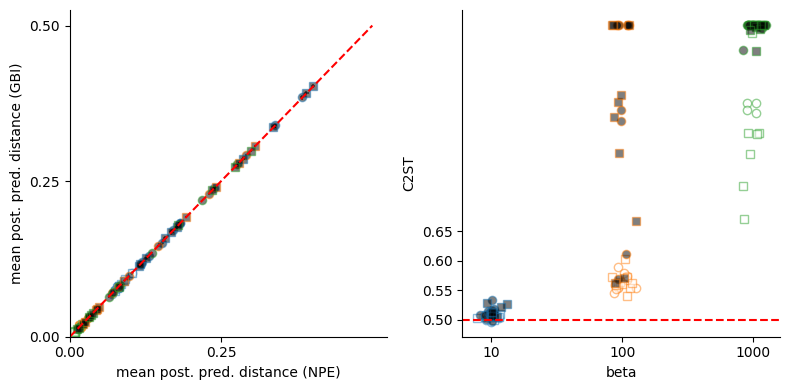

In [17]:
# with plt.rc_context(fname="../.matplotlibrc"):
plt.figure(figsize=(8,4))
markers = ['*', 'o', 's', '^']
ctr = 0
for i_s, is_specified in enumerate(['specified', 'misspecified']):
    for i_k, is_known in enumerate(['known', 'unknown']):
        print(is_specified, is_known)
        df_curr = df_summary[(df_summary['is_specified']==is_specified) & (df_summary['is_known']==is_known)]
        
        
        for i_r, (beta, rows) in enumerate(df_curr.groupby('beta')):
            plt.subplot(1,2,1)
            plt.errorbar(rows['ppd_npe_mean'].values, rows['ppd_gbi_mean'].values, 
                         xerr=rows['ppd_npe_std'].values/100*3, yerr=rows['ppd_gbi_std'].values/100*3, fmt=f'k', ls='', alpha=0.5)

            plt.plot(rows['ppd_npe_mean'].values, rows['ppd_gbi_mean'].values, 
                     f'C{i_r}', 
                     mfc='k' if i_s==1 else 'w', 
                     marker='o' if i_k==0 else 's',
                     mew=1,
                     ls='',
                     alpha=0.5)
        
            plt.subplot(1,2,2)
            plt.plot(i_r*np.ones_like(rows['c2st'])+np.random.randn(len(rows))*0.05, rows['c2st'], f'C{i_r}', 
                     mfc='k' if i_s==1 else 'w', 
                     marker='o' if i_k==0 else 's',
                     mew=1,
                     ls='',
                     alpha=0.5
                    )
        ctr+=1

plt.subplot(1,2,1)
plt.plot([0,.5], [0,.5], 'r--')
plt.xlabel('mean post. pred. distance (NPE)'); plt.ylabel('mean post. pred. distance (GBI)'); 
plt.xlim([0, None]);    plt.ylim([0, None]);
plt.xticks([0,0.25]);plt.yticks([0,0.25, 0.5]);
plt.gca().spines[['right', 'top']].set_visible(False)

plt.subplot(1,2,2)
plt.axhline(0.5, color='r', ls='--')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('beta');plt.ylabel('C2ST'); 
plt.xticks([0,1,2], labels=betas);plt.yticks([0.5, 0.55, 0.6, 0.65]);

plt.tight_layout()

In [117]:

def tempered_potential(potential_fn, beta):
    return potential_fn(posterior_samples)

tensor([-0.4540, -0.4283, -0.3058,  ..., -0.3525, -0.3588, -0.6657],
       grad_fn=<AddBackward0>)

In [94]:
posterior_predictives = task.simulate(posterior_samples)

(tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]),
 tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]))

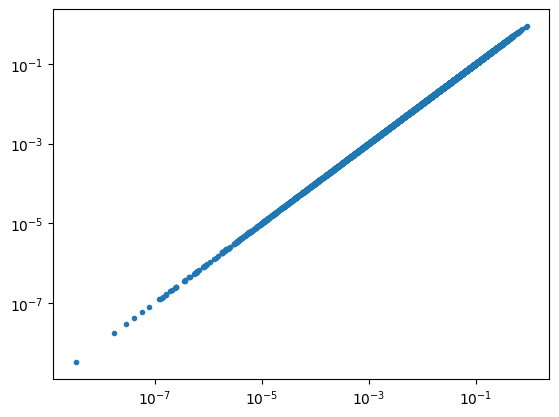

In [97]:

ppd = distance_func(posterior_predictives.unsqueeze(1), x_o)

plt.loglog(ppd, (posterior_predictives-x_o).pow(2).mean(1), '.')
ppd, (posterior_predictives-x_o).pow(2).mean(1)

In [69]:
c2st(posterior_samples, gt_samples)

tensor([0.8349])

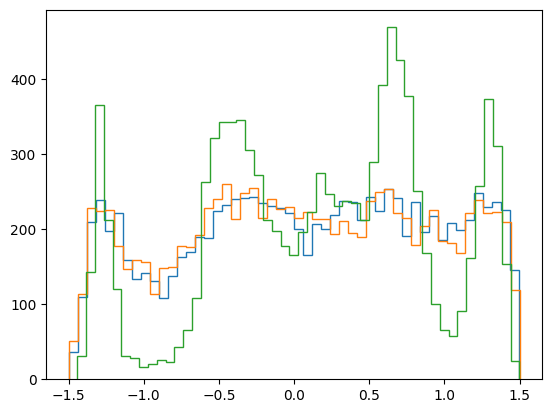

In [107]:
# plt.plot(gt_samples, torch.ones(gt_samples.size()), '.', alpha=0.1)
plt.hist(gt_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples_npe.numpy().squeeze(), 50, histtype='step');

# c2st(posterior_samples, gt_samples)

In [ ]:
task = UniformNoise1D()

# Train inference algorithms.
task.dist_func_gbi = distance_func

# Get trained inference object.
inference = gbi_utils.pickle_load(inference_folder + 'NPE.pickle')
print(inference)